In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Creating custom ShoeSandalBoot Dataset
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision.io import ImageReadMode
class BootSandalShoeDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = ['Boot', 'Sandal', 'Shoe']
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.length = 0
        for label in self.img_labels:
            self.length += len(os.listdir(os.path.join(img_dir, label)))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        label = self.img_labels[idx//5000]
        index = (idx%5000) + 1
        img_path = os.path.join(self.img_dir, label,  "{} ({}).jpg".format(label, index))
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    

In [6]:
from torchvision import transforms
image_size = 64
batch_size = 32

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

training_data = BootSandalShoeDataset(".\Shoe vs Sandal vs Boot Dataset", transform=preprocess)


In [7]:
from PIL import Image
import torchvision
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


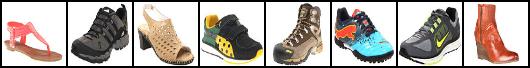

In [8]:

train_dataloader = torch.utils.data.DataLoader(
    training_data, batch_size=batch_size, shuffle=True
)
xb = next(iter(train_dataloader))[0][:8]
show_images(xb)

In [9]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [10]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [11]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

#30 is overkill for the dataset.
for epoch in range(13):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch[0].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]


        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()


    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:1, loss: 0.10274512385095615
Epoch:2, loss: 0.05697366163166347
Epoch:3, loss: 0.047456104892180925
Epoch:4, loss: 0.04444236535904631
Epoch:5, loss: 0.042609212364056216
Epoch:6, loss: 0.04065544319067047
Epoch:7, loss: 0.03775903627054015
Epoch:8, loss: 0.03744591979869902
Epoch:9, loss: 0.03633919023056783
Epoch:10, loss: 0.03561676202465031
Epoch:11, loss: 0.03553319376295627
Epoch:12, loss: 0.03542283370789053
Epoch:13, loss: 0.034307214016440324
Epoch:14, loss: 0.03414293825785234
Epoch:15, loss: 0.033401848029480305
Epoch:16, loss: 0.03282761847230989
Epoch:17, loss: 0.031815781049541574
Epoch:18, loss: 0.03330402807799229
Epoch:19, loss: 0.032138336324758494
Epoch:20, loss: 0.03166101942621251
Epoch:21, loss: 0.030540299552208834
Epoch:22, loss: 0.03191950471440294
Epoch:23, loss: 0.0320428503768594
Epoch:24, loss: 0.030801074769991294
Epoch:25, loss: 0.030959394027683527
Epoch:26, loss: 0.031011791238541416
Epoch:27, loss: 0.030382552545573285
Epoch:28, loss: 0.031686660

In [12]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

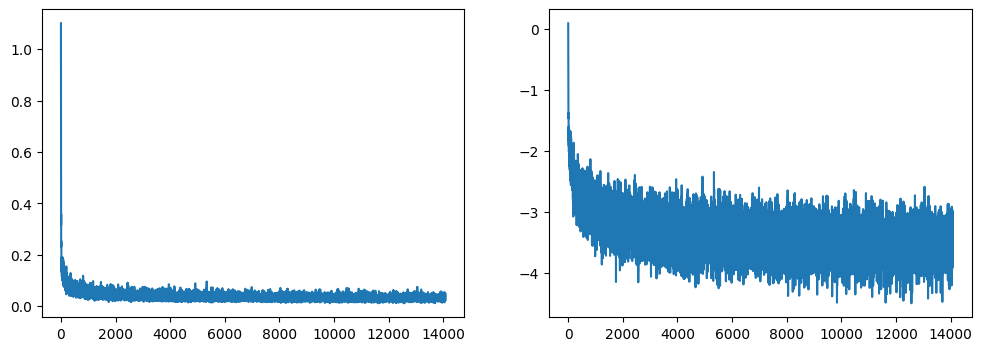

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

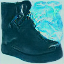

In [50]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [14]:
image_pipe.save_pretrained("my_pipeline_2")

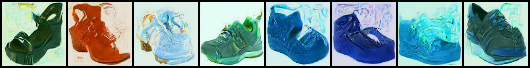

In [17]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 64, 64).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)